## MCMC with TPS OM

In [96]:
# def new_b(x, t): 
#     # assert x.shape[0] == ndims
#     return -jax.grad(lambda x: (x**4 - 8 * x**2))(x)

from mclmc import run_mclmc
import numpy as np
import jax
from path_sampling import dfdt, div_f, make_double_well_potential, sample_sde
import jax.numpy as jnp

ndims = 1 

hyperparams={'dt': 0.001, 'num_steps': 200, 'num_training_steps' : 1000}

time = np.arange(0,hyperparams['num_steps'])*hyperparams['dt']

uref = lambda x, t: -jax.grad(make_double_well_potential(v=5.0))(x)

path_key = jax.random.key(0)
xs, times = jax.pmap(lambda key:sample_sde(
    b = uref, 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    # rho = lambda key: jax.random.normal(key, shape=(ndims,))-2,
    rho = lambda key: jnp.zeros((ndims,))-1.,
    key=key, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(path_key, 1))


# def I_UREF_TPS(x, time, uref):
#     x = x.reshape((-1, ndims))
#     dt = time[1]-time[0]
#     dxdts = dfdt(x, dt)
#     div_us = div_f(x, time, uref)
#     out = jax.vmap(lambda xt,t, div_u, dxdt : 0.5*dt*(0.5*(dxdt - uref(xt, t)).dot(dxdt - uref(xt, t)) + 0.5*div_u)) (x, time, div_us, dxdts)
#     return jnp.sum(out)   

def I_UREF_TPS(x, time, b):
    x = x.reshape((-1, ndims))
    dt = hyperparams['dt']
    print(dt)
    dxdts = dfdt(x, dt)
    div_us = div_f(x, time, b)
    out = jax.vmap(lambda xt,t, div_u, dxdt : 0.5*dt*(0.5*(dxdt - b(xt, t)).dot(dxdt - b(xt, t)) + 0.5*div_u) )(x, time, div_us, dxdts)
    # div = jax.vmap(lambda xt,t, div_u, dxdt : div_u)(x, time, div_us, dxdts)
    # jax.debug.print("div {x}", x=jnp.sum(div))
    return jnp.sum(out)

J_UREF_TPS = lambda x,y: (1/0.1**2)*(x[-1,0] - 1)**2

# use mcmc with the onsager machlup functional to correct samples

def refine_path_exp(x, s, time, rng_key, num_steps):
    initial_position = x.reshape(x.shape[0]*x.shape[1])

    # logdensity_fn = lambda x: jax.scipy.stats.norm.logpdf(x[0], loc=-2, scale=0.01)-I_exp(x, time, lambda k, t: uref(k,t)) 
    logdensity_fn = lambda x: jax.scipy.stats.norm.logpdf(x[0], loc=-1, scale=0.01)-I_exp(x, time, uref) - s*J(x.reshape((-1, ndims)), None)

    # logdensity_fn = lambda x: I(x, time, uref) 

    samples, _, params, chain_key = run_mclmc(
        logdensity_fn=logdensity_fn,
        num_steps=num_steps,
        initial_position=initial_position,
        key=rng_key,
        transform=lambda state, info: state.position
    )

    return samples[-1]



samples = refine_path_exp(
    x=xs[0],
    s=0.0,
    time=time,
    rng_key=jax.random.key(1),
    num_steps=400000
)



0.001
0.001
0.001
0.001
0.001
0.001
0.001


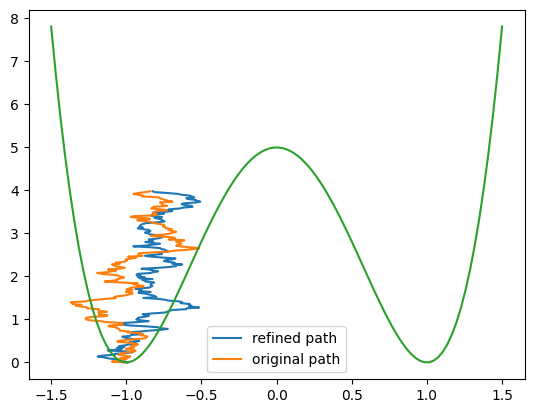

In [97]:
# plot samples and potential
import matplotlib.pyplot as plt

# plot
plt.plot(samples,(time/hyperparams['dt'])/50, label='refined path')
plt.plot(xs[0],(time/hyperparams['dt'])/50, label='original path')
plt.legend()
x = np.linspace(-1.5, 1.5, 100)
potential = jax.vmap(make_double_well_potential(v=5.0))
plt.plot(x, potential(x[:, None]))
# plt.plot(time, xs[0], label='original path')

In [98]:
print(
    (I_UREF_TPS(samples, time, uref)),
    (I_UREF_TPS(xs[0], time, uref))
)

0.001
0.001
114.697395 112.15501


0.001
103.72724


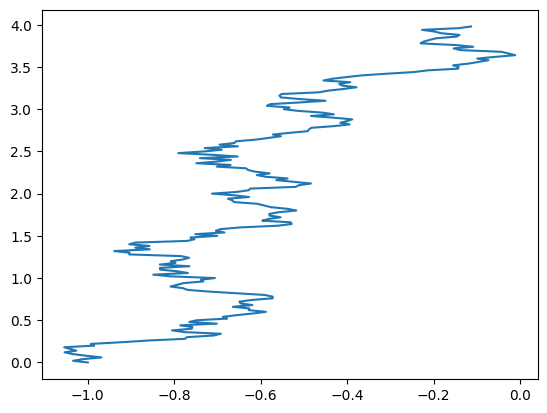

In [100]:
brownian_bridge_drift = lambda x,t: (1 - x)/(1-t)
path_key = jax.random.key(1)
xs_brownian_bridge, times = jax.pmap(lambda key:sample_sde(
    b=brownian_bridge_drift, 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    # rho = lambda key: jax.random.normal(key, shape=(ndims,))-2,
    rho = lambda key: jnp.zeros((ndims,))-1.,
    key=key, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(path_key, 1))

print(I_UREF_TPS(xs_brownian_bridge[0], time, uref))
plt.plot(xs_brownian_bridge[0],(time/hyperparams['dt'])/50, label='brownian bridge path')

In [85]:
# hyperparams={'dt': 0.001, 'num_steps': 200, 'num_training_steps' : 1000}

# time = np.arange(0,hyperparams['num_steps'])*hyperparams['dt']


# path_key = jax.random.key(1)
# xs, times = jax.pmap(lambda key:sample_sde(
#     b=uref, 
#     W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
#     # rho = lambda key: jax.random.normal(key, shape=(ndims,))-2,
#     rho = lambda key: jnp.zeros((ndims,))-1.,
#     key=key, 
#     dt=hyperparams['dt'], 
#     num_steps=hyperparams['num_steps']))(jax.random.split(path_key, 1))


# def I_exp(x, time, b):
#     x = x.reshape((-1, ndims))
#     dt = hyperparams['dt']
#     print(dt)
#     dxdts = dfdt(x, dt)
#     div_us = div_f(x, time, b)
#     out = jax.vmap(lambda xt,t, div_u, dxdt : 0.5*dt*(0.5*(dxdt - b(xt, t)).dot(dxdt - b(xt, t)) + 0.5*div_u) )(x, time, div_us, dxdts)
#     # div = jax.vmap(lambda xt,t, div_u, dxdt : div_u)(x, time, div_us, dxdts)
#     # jax.debug.print("div {x}", x=jnp.sum(div))
#     return jnp.sum(out)

# J = J_UREF_TPS

# # use mcmc with the onsager machlup functional to correct samples

# def refine_path_exp(x, s, time, rng_key, num_steps):
#     initial_position = x.reshape(x.shape[0]*x.shape[1])

#     # logdensity_fn = lambda x: jax.scipy.stats.norm.logpdf(x[0], loc=-2, scale=0.01)-I_exp(x, time, lambda k, t: uref(k,t)) 
#     logdensity_fn = lambda x: jax.scipy.stats.norm.logpdf(x[0], loc=-1, scale=0.01)-I_exp(x, time, uref) - s*J(x.reshape((-1, ndims)), None)

#     # logdensity_fn = lambda x: I(x, time, uref) 

#     samples, _, params, chain_key = run_mclmc(
#         logdensity_fn=logdensity_fn,
#         num_steps=num_steps,
#         initial_position=initial_position,
#         key=rng_key,
#         transform=lambda state, info: state.position
#     )

#     return samples[-1]




# samples = refine_path_exp(
#     x=xs[0],
#     s=0.0,
#     time=time,
#     rng_key=jax.random.key(1),
#     num_steps=100000
# )

0.001
0.001
0.001
0.001
0.001
0.001
0.001


In [89]:
# # plot samples and potential
# import matplotlib.pyplot as plt

# # plot
# plt.plot(samples,(time/hyperparams['dt'])/50, label='refined path')
# plt.plot(xs[0],(time/hyperparams['dt'])/50, label='original path')
# plt.legend()
# x = np.linspace(-1.5, 1.5, 100)
# potential = jax.vmap(make_double_well_potential(v=5.0))
# plt.plot(x, potential(x[:, None]))
# # plt.plot(time, xs[0], label='original path')

0.001
0.001
92.41061 103.58521
